In [2]:
import time
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
from pathlib import Path

In [4]:
import sys
sys.path.append("/home/moon/project/prediction-project")

In [5]:
load_data = pd.read_csv("../data/raw/load/load_data.csv")
solar_data = pd.read_csv("../data/raw/solar/solar_data.csv")

In [6]:
from src.metrics import RMSE, MAPE, SMAPE
from src import transform as tr
from src.preprocess import *
from src import configurations as cfg

Package root: /home/moon/project/prediction-project/notebooks


In [7]:
class LoadDataset(object):
    def __init__(self,
                 upstream_directory:str,
                 file_prefix: str,
                 file_name: str,
                 ):
        
        self.upstream_directory = upstream_directory
        self.file_prefix = file_prefix
        self.file_name = file_name
        
    def pandas_reader_dataset(self, target:str, time_column:str | None, timedeltas: list[str] | None) -> tuple[pd.DataFrame, pd.Series]:
        file_paths = str(
            Path() / self.upstream_directory / self.file_prefix / self.file_name
        )
        df = pd.read_csv(file_paths)
        if time_column is not None:
            df_ = self.transform_process(df, timedeltas, time_column, target)
            X = df_.drop(labels=[target], axis=1)
            y = df_[target]
            return X, y
        
        X = df.drop(labels=[target], axis=1)
        y = df[target]
        
        return X, y


    def transform_process(self, df:pd.DataFrame, timedeltas:list[str] | None, time_column:str="Forecast_time", target:str="load") -> pd.DataFrame:
        tr.set_time_index(df,time_column)
        df = tr.create_time_features(df)
        
        df = tr.create_time_lag_features(df, target=target, timedeltas=timedeltas)
        hour_group_energy = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='mean')
        hour_group_energy_std = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='std')
        dayweek_hour_gruop_energy = tr.grouped_frame(df=df, group_col_list=["dayofweek", "hour"], target_col_list=[target], method="mean")
        df['hour_mean'] = df.apply(lambda x: hour_group_energy.loc[(hour_group_energy.hour == x['hour']), f'{target}_mean'].values[0], axis=1)
        df['hour_std'] = df.apply(lambda x: hour_group_energy_std.loc[(hour_group_energy_std.hour == x['hour']), f'{target}_std'].values[0], axis=1)
        df['dayweek_hour_mean'] = df.apply(lambda x: dayweek_hour_gruop_energy.loc[(dayweek_hour_gruop_energy.hour == x['hour']) & (
            dayweek_hour_gruop_energy.dayofweek == x['dayofweek']), f'{target}_mean'].values[0], axis=1)
        
        return df
    
    
def get_input_pipeline(
    numerical_features: list,
    categorical_features: list,
):
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor

In [8]:
train_set = LoadDataset(upstream_directory="../data/preprocess/load/", file_prefix="", file_name="load_train.csv")
test_set = LoadDataset(upstream_directory="../data/preprocess/load/", file_prefix="", file_name="load_test.csv")

In [9]:
X_train, y_train = train_set.pandas_reader_dataset(timedeltas=cfg.LoadFeatureConfigurations.TIMEDELTAS, target="demand", time_column="timestamp")
X_test, y_test = test_set.pandas_reader_dataset(timedeltas=cfg.LoadFeatureConfigurations.TIMEDELTAS, target="demand", time_column="timestamp")

In [10]:
X_train.dropna().head()

,load_id,temperature,humidity,hour,month,dayofweek,quarter,dayofyear,dayofmonth,lag_1 days,lag_2 days,lag_3 days,lag_7 days,hour_mean,hour_std,dayweek_hour_mean
timestamp,,,,,,,,,,,,,,,,
2024-05-25 00:00:00,1,1.2,50.4,0,5,5,2,146,25,3844.3125,3759.7350,3412.5300,2456.0425,3081.428199,701.241043,3378.147917
2024-05-25 01:00:00,1,0.5,52.6,1,5,5,2,146,25,4238.2600,4125.8625,3997.8850,2570.6650,3368.326406,818.093879,3739.010521
2024-05-25 02:00:00,1,-0.2,54.4,2,5,5,2,146,25,4280.5475,4202.6475,4062.4300,2389.2700,3380.237924,826.139617,3753.500260
2024-05-25 03:00:00,1,-0.6,56.4,3,5,5,2,146,25,4301.6900,4246.0475,4046.8475,2330.2925,3348.472173,819.374239,3721.784271
2024-05-25 04:00:00,1,-0.8,57.3,4,5,5,2,146,25,4293.3450,4178.1675,4041.8425,2244.0450,3359.223132,853.987063,3769.022292


In [11]:
print(f"Shape of X_train {X_train.shape} and y_train {y_train.shape}")
print(f"Shape of X_test {X_test.shape} and y_test {y_test.shape}")

Shape of X_train (8064, 16) and y_train (8064,)
Shape of X_test (720, 16) and y_test (720,)


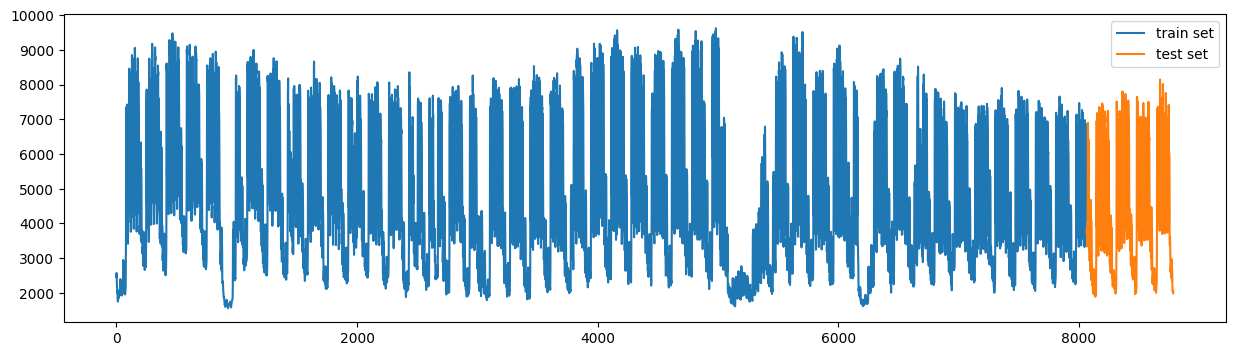

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

train_load = y_train
test_load = y_test

indices = list(range(train_load.shape[0] + test_load.shape[0]))

axes.plot(indices[:train_load.shape[0]], train_load, label="train set")
axes.plot(indices[train_load.shape[0]:], test_load, label="test set")
axes.legend()

In [13]:
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
print("현재 사용 중인 디바이스:", torch.cuda.current_device())
print("디바이스 이름:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA 사용 가능 여부: True
현재 사용 중인 디바이스: 0
디바이스 이름: NVIDIA GeForce RTX 4060 Ti


In [14]:
class DeepResidualMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2)            
            
        )
        self.res1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
        )
        
        self.res2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.res1(x) + x
        x = self.res2(x) + x
        x = self.out(x)
        return x

In [15]:
class LoadTorchDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
       
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
numerical_features = cfg.LoadFeatureConfigurations.NUM_FEATURES
categorical_features = cfg.LoadFeatureConfigurations.CAT_FEATURES
preprocessor = get_input_pipeline(numerical_features, categorical_features)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [18]:

X_train_scaled = preprocessor.fit_transform(X_train)
X_valid_scaled = preprocessor.transform(X_valid)
X_test_scaled = preprocessor.transform(X_test)


In [19]:

train_dataset = LoadTorchDataset(X_train_scaled, y_train)
valid_dataset = LoadTorchDataset(X_valid_scaled, y_valid)
test_dataset = LoadTorchDataset(X_test_scaled, y_test)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=256)
val_loader = DataLoader(valid_dataset, batch_size=256)

In [21]:
test_loader = DataLoader(test_dataset, batch_size=256)

In [22]:
model = DeepResidualMLP(input_dim=X_train_scaled.shape[1])

In [23]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs=300,
    patience=50,
    min_delta=1e-4,
    lr=1e-3,
    weight_decay=1e-4,
    scheduler_patience=10,
    factor=0.5,
    save_path="best_model.pt",
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=scheduler_patience, factor=factor, verbose=True
    )

    best_model = deepcopy(model.state_dict())
    best_loss = float("inf")
    wait = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_loss = criterion(model(X_val), y_val)
                val_losses.append(val_loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(
            f"Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )
        scheduler.step(val_loss)

        if val_loss + min_delta < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model.state_dict())
            wait = 0
            torch.save(best_model, save_path)
        else:
            wait += 1
            if wait >= patience:
                print(
                    f"⏹ Early stopping at epoch {epoch}. Best Val Loss: {best_loss:.4f}"
                )
                break

    model.load_state_dict(best_model)
    model.to("cpu")

    return model, train_loss_history, val_loss_history

def plot_loss(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

In [24]:
model, train_loss_history, val_loss_history = train_model(
    model,
    train_loader,
    val_loader,
    epochs=2000,
    min_delta=1e-5,
    lr=1e-2,
    patience=500,
    save_path="best_model.pt",
)

Epoch 000, Train Loss: 20116705.0385, Val Loss: 11749773.0000
Epoch 001, Train Loss: 4676948.8510, Val Loss: 975577.2411
Epoch 002, Train Loss: 1234061.3534, Val Loss: 887045.0893
Epoch 003, Train Loss: 1092837.0312, Val Loss: 840072.0357
Epoch 004, Train Loss: 1069902.4087, Val Loss: 808996.0714
Epoch 005, Train Loss: 1054476.2668, Val Loss: 808077.5625
Epoch 006, Train Loss: 1060300.8750, Val Loss: 832611.4018
Epoch 007, Train Loss: 1054336.0216, Val Loss: 796491.4018
Epoch 008, Train Loss: 1053461.9615, Val Loss: 795656.5625
Epoch 009, Train Loss: 1039315.5385, Val Loss: 795877.2589
Epoch 010, Train Loss: 1051560.5505, Val Loss: 803728.7500
Epoch 011, Train Loss: 1063188.1298, Val Loss: 799468.8214
Epoch 012, Train Loss: 1045976.6058, Val Loss: 822881.2321
Epoch 013, Train Loss: 1044993.8990, Val Loss: 792155.1964
Epoch 014, Train Loss: 1037173.2524, Val Loss: 794863.9554
Epoch 015, Train Loss: 1042267.5120, Val Loss: 791411.1250
Epoch 016, Train Loss: 1042709.3293, Val Loss: 803796

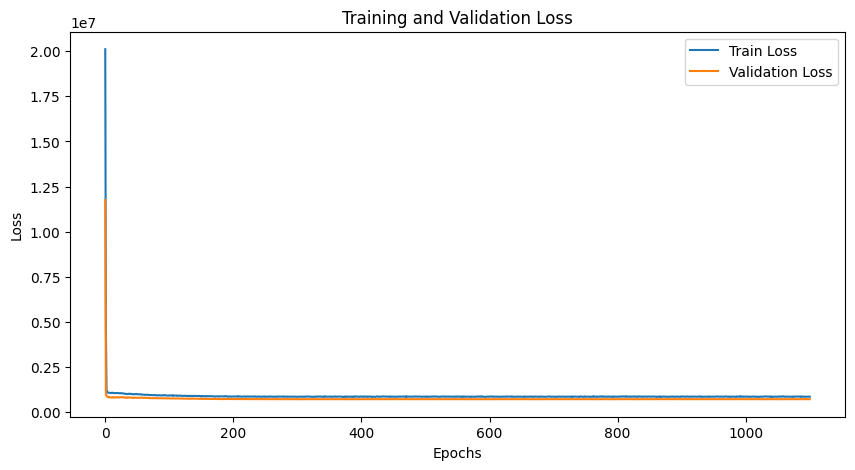

In [25]:
plot_loss(train_loss_history, val_loss_history)

In [26]:
X_proc = preprocessor.transform(X_test)
X_tensor = torch.tensor(X_proc, dtype=torch.float32)

model = DeepResidualMLP(input_dim=X_tensor.shape[1])
model.load_state_dict(
    torch.load("best_model.pt", map_location=torch.device("cpu"))
)
model.eval()

with torch.no_grad():
    y_pred = model(X_tensor).numpy()

y_test["prediction"] = y_pred.reshape(
    -1,
)
print("✅ 예측 완료 → predicted_result.csv 저장됨.")

✅ 예측 완료 → predicted_result.csv 저장됨.


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
y_preds = []
with torch.no_grad():
    for X_test_, y_test_ in test_loader:
        X_test_, y_test_ = X_test_.to(device), y_test_.to(device)
        y_pred = model(X_test_)
        y_preds.append(y_pred.cpu().numpy())
y_preds = np.concatenate(y_preds, axis=0)

In [42]:
y_preds.shape

(720, 1)

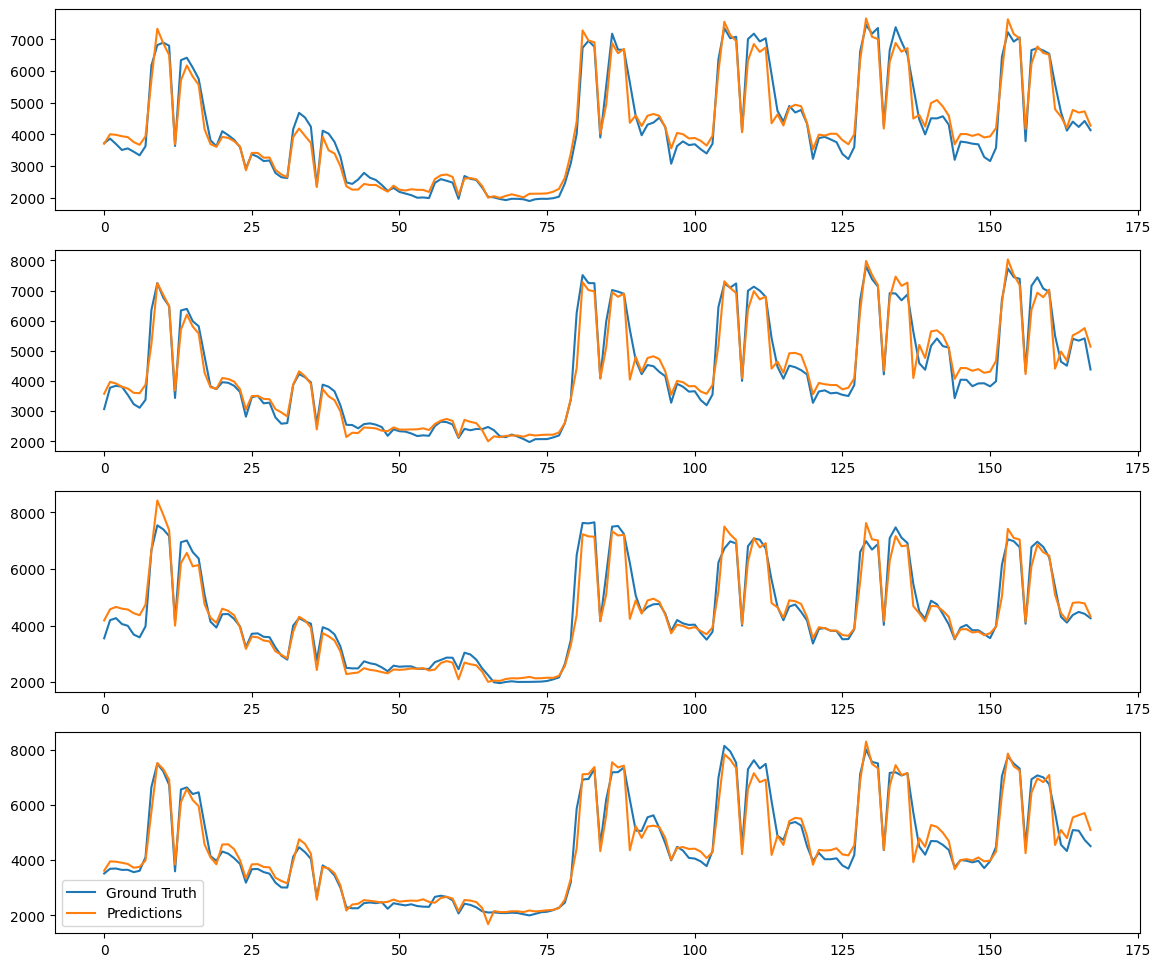

In [43]:
y_trues = y_test.iloc[:-1].values
y_preds = y_preds.reshape(-1,)


fig, axes = plt.subplots(4, 1, figsize=(14, 12))

step = 168
ax_i = 0
for i in range(0, y_test.shape[0], step):
    if ax_i > 3:
        break
    axes[ax_i].plot(y_trues[i:i+step], label="Ground Truth")
    axes[ax_i].plot(y_preds[i:i+step], label="Predictions")
    ax_i += 1
plt.legend()


In [44]:
# Evaluate predictions
mae_score = mean_absolute_error(y_trues, y_preds)
mse_score = mean_squared_error(y_trues, y_preds)
rmse_score = RMSE(y_trues, y_preds)
mape_score = MAPE(y_trues, y_preds)
smape_score = SMAPE(y_trues, y_preds)

# Log model performance metrics to W&B
print({"rmse": rmse_score, "mae": mae_score, "mse": mse_score, "mape":mape_score, "smape": smape_score})

{'rmse': 416.1964368134566, 'mae': 285.955287109375, 'mse': 173219.47401621757, 'mape': 7.050709889926354, 'smape': 3.453562900047391}
